# Heizdraht Anemometer CTA/CCA

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import floor, ceil, log10
import pandas as pd
import codecs

# https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
# https://stackoverflow.com/questions/23207055/rounding-errors-to-1-significant-figure-and-round-values-according-to-number-of
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(x))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(x)))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtn = round_to_n
rtr = round_to_reference

# Fit
def Kings_Law (x, const, m, B):
    y = const + m * (x-B)**4
    return y

# Returns flow velocity and uncertainty
def U_Düse_in_v(U):
    return (U*4.749, U*0.031)

label_size = 20
plt.rcParams.update({'font.size': label_size, 'legend.title_fontsize': 16, 'legend.fontsize': 16, "axes.labelsize": label_size, "xtick.labelsize": label_size, 
"ytick.labelsize": label_size, "axes.labelpad": 4, "lines.markersize": 10, "lines.linewidth": 2})

### CTA Kalibrierung


U=8: const, m, B
1.562990906840735 0.015260451406114057 9.654629407783638

U=10: const, m, B
1.2319212966152513 0.0005800934701699694 7.614278444651751

U=12: const, m, B
0.19279956072229903 0.00020415258228362679 4.519732916145089

U=8: const, m, B
1.562990906840735 0.015260451406114057 9.654629407783638

U=10: const, m, B
1.2319212966152513 0.0005800934701699694 7.614278444651751

U=12: const, m, B
0.19279956072229903 0.00020415258228362679 4.519732916145089


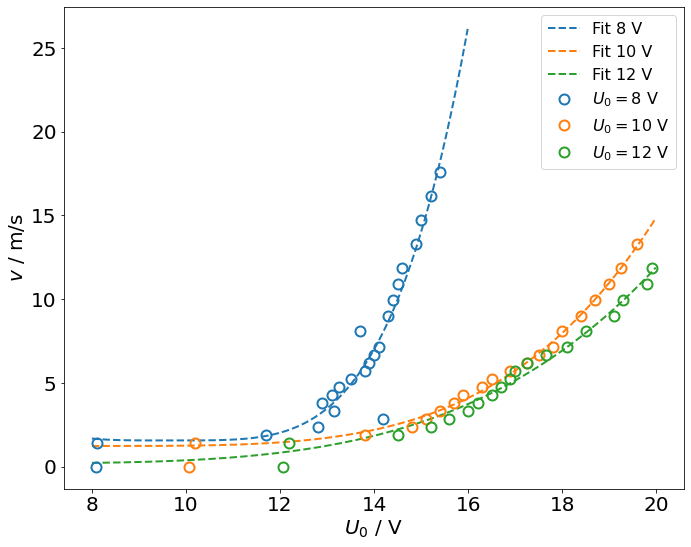

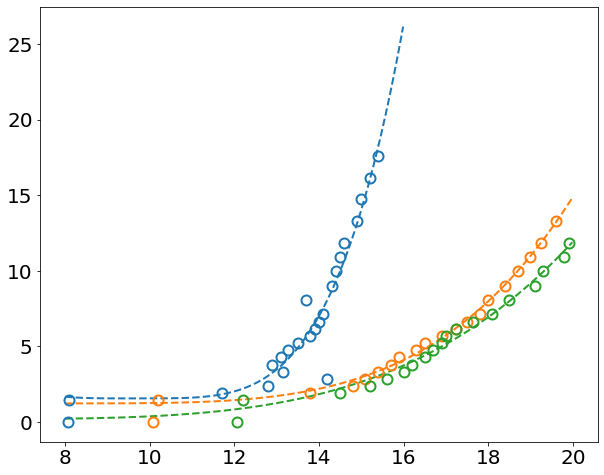

In [48]:
U = np.array([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.1, 3.4, 3.7])
(v, delta_v) = U_Düse_in_v(U)
U_0_8 = np.array([8.08, 8.1, 11.7, 12.8, 14.2, 13.14, 12.9, 13.1, 13.26, 13.5, 13.8, 13.9, 14, 14.1, 13.7, 14.3, 14.4, 14.5, 14.6, 14.9, 15, 15.2, 15.4])
U_0_10 = np.array([10.07, 10.2, 13.8, 14.8, 15.1, 15.4, 15.7, 15.9, 16.3, 16.5, 16.9, 17.25, 17.5, 17.8, 18, 18.4, 18.7, 19, 19.25, 19.6])
U_0_12 = np.array([12.07, 12.2, 14.5, 15.2, 15.6, 16, 16.2, 16.5, 16.7, 16.9, 17, 17.25, 17.65, 18.1, 18.5, 19.1, 19.3, 19.8, 19.9])
U_total = np.arange(8,16,0.01)


fig, ax = plt.subplots(1,1,figsize=(10,8))
for i, (data, VOLT) in enumerate(zip([U_0_8, U_0_10, U_0_12], [8, 10, 12])):
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [0, 1, VOLT]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(8, ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    print(*parameters)

    label=f"Fit {VOLT} V"
    (const, m, B) = rtn(parameters, 2)
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V")
ax.legend()
plt.tight_layout()
plt.savefig("Abb/Heizdraht_3_2_CTA.png")




### Moved


U=8: const, m, B
1.5629905963687942 0.015260448262247001 1.574629103281543

U=10: const, m, B
1.2319207579656757 0.0005800932196434389 -2.4557229222644734

U=12: const, m, B
0.19281293828902019 0.00020415422218304546 -7.550232593089755


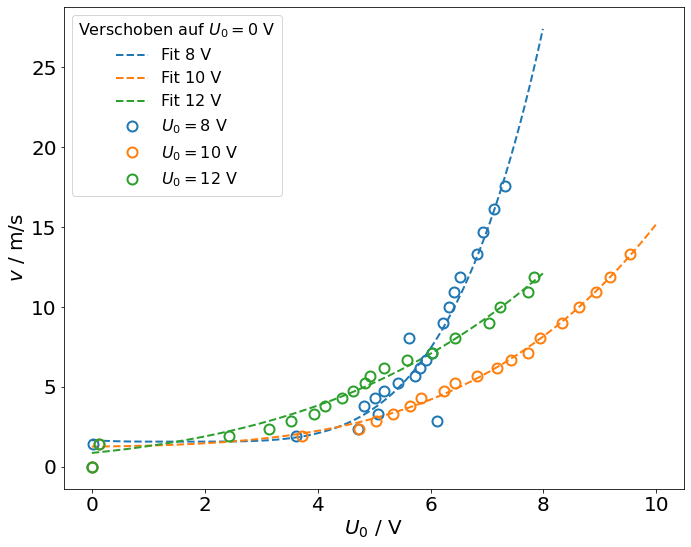

In [66]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for i, (data, VOLT) in enumerate(zip([U_0_8, U_0_10, U_0_12], [8, 10, 12])):
    data = data-data[0]
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
    guess = [0, 1, 0]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    # std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(0, ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    print(*parameters)

    label=f"Fit {VOLT} V"
    # (const, m, B) = rtn(parameters, 2)
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V")
ax.legend(title="Verschoben auf $U_0 = 0$ V")
plt.tight_layout()
plt.savefig("Abb/Heizdraht_3_2_CTA_Verschoben.png")

In [3]:
data_dict = {"$U / \mathrm{V}$": U_0, "$U_{0,8} / \mathrm{V}$": U_0_8, "$U_{0,10} / \mathrm{V}$": U_0_10, "$U_{0,12} / \mathrm{V}$": U_0_12}
df = pd.DataFrame(data = data_dict)
# print(df.transpose().to_latex(header=False))
caption = r"???"
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA", caption=caption))
with codecs.open("Tabellen/Heizdraht_CTA.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA", caption=caption))

NameError: name 'U' is not defined